---
layout: post
comments: true
tags: dementia data-vizualization feature-engineering R-stats RNA-seq
title: Differential Expression Analysis for Feature Engineering/Dimension Reduction
---

In [ ]:
setwd(..)

We're back! 

In this post, I'll be sharing some of the results of the differential gene expression analysis I recently did using the RNA-seq gene expression data from the Allen Institute for Brain Science's [*Aging, Dementia, & TBI Study*](http://aging.brain-map.org/). This is part of an exploratory analysis I conducted prior to constructing models of dementia status using this and other data collected from postmortem brain tissue samples. The idea is to mine this data for information about factors contributing to dementia risk.  

One major hurdle is the number of possible features. There are expression levels for 50,000+ genes in the dataset, each of which we can consider as a potential feature. It's likely that most of those 50,000+ will not exhibit differences with dementia. We can reduce the size of the dataset by determining which genes have expression levels that are significantly different between Dementia and No Dementia samples. 

#### To recap
At this point, we have:  

* [Loaded the gene expression data](http://blog.vislaywade.com/allen-dementia-gene-expression-data-load-R/) from the study website,  
* [Used multidimensional scaling](http://blog.vislaywade.com/EDA-gene-expression-data-part-1-multidimensional-scaling/) to visualize relationships among the samples (including some [interactive plots](http://blog.vislaywade.com/interactive-MDS-plots-w-plotly/)), and;  
* [Performed hypothesis testing](http://blog.vislaywade.com/EDA-gene-expression-data-part-2-hypothesis-testing/) to find genes that are expressed differently in Dementia versus No Dementia samples.  

The multidimensional scaling plots suggested that the region of the brain the tissue sample came from or the sex of the donor might account for the greatest differences between gene expression profiles. Based on this result, we subset the samples both by brain region and by donor sex and looked for differentially expressed genes *within those groups*.

#### On tap for this post...  
1. *Identifying differentially expressed genes* - Using Venn diagrams, we'll take a look at how the cohort of genes we identify as differentially-expressed varies between brain region.  
2. *Visualizations of expression levels for differentially expressed genes* - We'll use heatmaps and hierarchical clustering to dive into the expression patterns of the genes discussed in Part 1.  
3. *Conclusions & next steps* - We'll discuss the results and what's up next.  

All of the visualizations here (and more!) can be recreated from a script in the `EDA` folder of the [project repo](https://github.com/brilliantFire/Allen-aging-dementia-TBI) on GitHub (see the repo `README.md` for details). There's a Jupyter notebook version of this post in the repo, too.  

Let's get started!

### Identifying differentially-expressed genes
First, let's load the libraries we'll use.

In [2]:
library(data.table)   # I/O
library(dplyr)        # Entering the TIDYVERSE :)
library(VennDiagram)  # For drawing Venn diagrams 
library(gplots)       # For more Venn stuff + heatmaps
library(edgeR)        # test result classification
library(reshape2)     # split open and melt some dataframes
library(ggplot2)      # other visualizations


Attaching package: 'dplyr'

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: grid
Loading required package: futile.logger

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Warning message:
"package 'edgeR' was built under R version 3.4.3"Loading required package: limma
Warning message:
"package 'limma' was built under R version 3.4.3"
Attaching package: 'reshape2'

The following objects are masked from 'package:data.table':

    dcast, melt



Here, we load both the test results and the normalized count matrix for each brain region group. We'll limit ourselves to just the brain region groups for now. The code here assumes we're running the notebook version of this post from a cloned copy of the [project repo](https://github.com/brilliantFire/Allen-aging-dementia-TBI) where the output of previous scripts is in the `data` directory.

In [3]:
# load dataframes with normalized counts and dispersions
load_norm <- function(group, ...){
    x_norm <- readRDS(file=paste('data/',group,'_norm_counts_disp_high_low.Rds',sep=''))
    return(x_norm)
}

# load filtered results of exact tests + corrections for multiple comparisons
load_results <- function(group, disp, ...){
    x_results <- data.frame(readRDS(file=paste('data/',group,'_exact_test_results_p.02_high_low_',disp,'.Rds',sep='')))
    return(x_results)
}

# loop loads data for all 4 brain region groups
groups <- c('hip', 'fwm', 'pcx', 'tcx')
for (group in groups){
    print(paste('Loading', group, 'group.'))
    flush.console()
    # make variables names
    norm_name <- paste(group,'_norm',sep='')
    results_name <- paste(group, '_results',sep='')
    # Assign output of load_norm and load_results to variable names
    assign(norm_name, load_norm(group))
    assign(results_name, load_results(group, 'auto'))
}

[1] "Loading hip group."
[1] "Loading fwm group."
[1] "Loading pcx group."
[1] "Loading tcx group."


We used the `topTags()` function to correct for multiple comparisons using the Benjamini-Hochburg procedure  to control the [false discovery rate (FDR)](https://en.wikipedia.org/wiki/False_discovery_rate). The FDR is the proportion of results that we expect to be false positives. In other words, it's the percentage of genes that we say are differentially expressed in dementia but actually aren't. The lists we working with here contain *all* the genes in each brain region group with expression levels that differ significantly between Dementia and No Dementia samples at the $\alpha=0.02$ level.

The function below filters the list of genes by a specified adjusted p-value (contained in the `FDR` attribute) and returns the gene names. By setting `alpha` equal to 0.1 here, all the gene names are returned for each group. If we wanted to look at more stringent cutoffs (e.g. $\alpha = 0.01$), we could using this function. For now, we'll be looking at all the genes in the lists.

In [4]:
# Function gets the names of genes with adjusted p-values (FDR) below a user-defined significance threshold; returns the list
get_sig_genes <- function(test_results, alpha, ...){
    # get names of genes with p <= p_value
    x_names <- rownames(test_results)[test_results$FDR <= alpha]
    # return list
    return(x_names)
}

# p.value = 0.1 here returns all genes
hip_genes <- get_sig_genes(hip_results, 0.1)
fwm_genes <- get_sig_genes(fwm_results, 0.1)
pcx_genes <- get_sig_genes(pcx_results, 0.1)
tcx_genes <- get_sig_genes(tcx_results, 0.1)

We can use a Venn diagram to look at how many of the genes overlap between the lists generated for the four brain regions. There's a bunch of methods out there to make Venn diagrams in R. Here we use `venn.diagram()` from the [`VennDiagram` library](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-35). I like this method since it allows for easy customization of all sorts of graphical parameters.

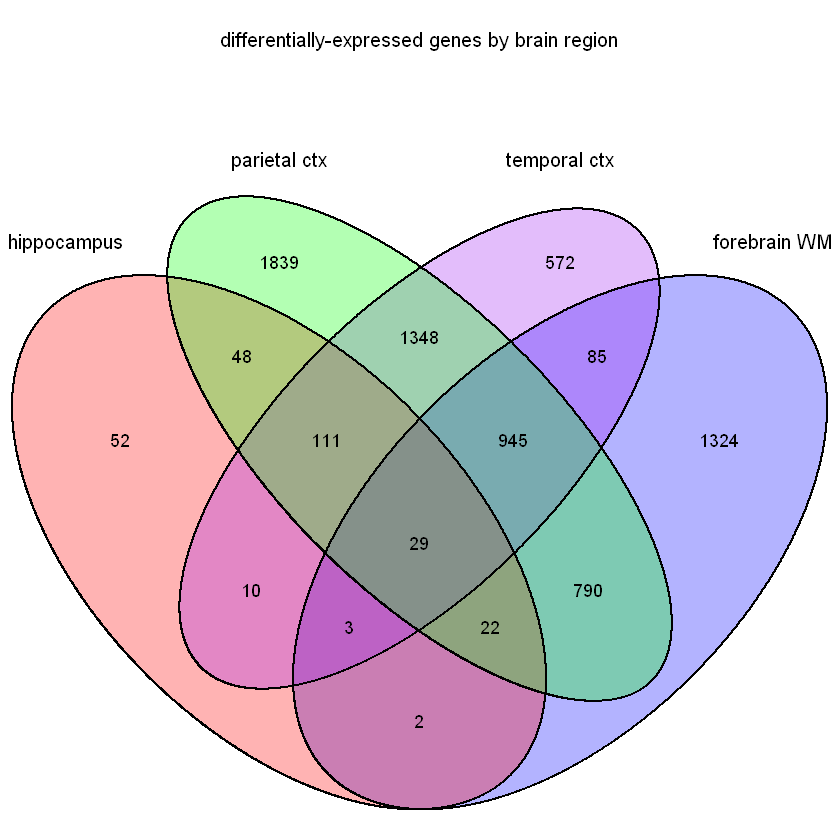

In [5]:
# use venn.diagram from the VennDiagram library
brain_reg_venn <- venn.diagram(list(hip_genes=hip_genes,
                                    fwm_genes=fwm_genes,
                                    pcx_genes=pcx_genes,
                                    tcx_genes=tcx_genes) , 
                               filename = NULL,
                               imagetype='png',
                               fill=c('red', 'blue', 'green', 'purple'),
                               alpha=c(0.3,0.3,0.3,0.3), # transparency
                               cex = 0.9, 
                               fontfamily='sans',
                               cat.fontfamily='sans',
                               category.names=c('hippocampus', 'forebrain WM', 'parietal ctx', 'temporal ctx'), 
                               main.fontfamily='sans',
                               main='differentially-expressed genes by brain region',
                               margin=0.001)

# use grid.draw to show the plot                         
grid.draw(brain_reg_venn)

Only 29 of the genes identified as differentially-expressed in dementia under these conditions overlap between the four brain regions. We can grab their Entrez IDs using the `venn()` function from `gplots`. These ID numbers will allow us to identify the genes in the [NCBI Gene database system](https://www.ncbi.nlm.nih.gov/gene/). The Entrez IDs of the genes in each section of the Venn diagram are contained in an attribute called `intersections`. We'll pull out the 29 genes at the intersection of all four brain regions (`intersection_genes`).

In [6]:
# use venn() from the gplots library to inspect contents
venn_contents <- venn(list(hip_genes=hip_genes,
                           fwm_genes=fwm_genes,
                           pcx_genes=pcx_genes,
                           tcx_genes=tcx_genes), show.plot=FALSE)
# grab the intersections
venn_intersections <- attr(venn_contents, 'intersections')
# 29 genes in the intersection of all 4 brain regions
intersection_genes <- venn_intersections$`hip_genes:fwm_genes:pcx_genes:tcx_genes`

### Visualizing expression levels for differentially-expressed genes
Heatmaps are a great way of visualizing a matrix of gene expression levels. To look at the differences in expression levels for the 29 intersection genes, we'll use the normalized matrix of FPKM values available from the [Allen Institute](http://aging.brain-map.org/download/index).  

FPKM stands for 'Fragments Per Kilobase per Million'. These values are *counts that have been normalized for gene length*. By virtue of how RNA-seq works and how the data are analyzed, the counts we have are biased towards genes that are longer. Normalizing for gene length eliminates that bias, so we can make reasonable conclusions about the relative expression of one gene versus another *within the same sample*.

We also need to be able to make comparisons *across samples*, so, in addition to being normalized for gene length, we also want our matrix to be normalized for technical variation *between samples*. The importance of between-sample normalization was discussed in [a previous post](http://blog.vislaywade.com/EDA-gene-expression-data-part-1-multidimensional-scaling/). The data we'll use here are available already normalized for between-sample technical variation (see [the data documentation called 'Quantitative Data Generation'](http://help.brain-map.org/display/aging/Documentation) for details).

##### Extracting data from a .zip file using R  
The data we're after are available in an archive file format ([.zip](https://en.wikipedia.org/wiki/Zip_(file_format)). We need two .csv files from the .zip: `fpkm_table_normalized.csv` and `rows-genes.csv`. The first is the matrix of normalized counts and the second is a list of gene names, chromosome loci, and other information, including the Entrez database numbers we're using as the row names in our count matrices. We'll use `utils::download.file()` to download the .zip to a temp file and `utils::unz()` to unzip them. The FPKM table is a big file so this might take a while. We'll time it to see how long it takes.

In [7]:
# start a timer
start <- Sys.time()

# get normalized FPKM data (.zip file) from Allen download page
temp <- tempfile()
download.file('http://aging.brain-map.org/api/v2/well_known_file_download/502999992', temp, mode='wb')

# get list of genes out of the .zip
rows_genes_table <- unz(temp, 'rows-genes.csv')
genes <- data.frame(read.csv(rows_genes_table, header=TRUE))

# get normalized FPKM table
fpkm_table <- unz(temp, 'fpkm_table_normalized.csv')
fpkm <- data.frame(read.csv(fpkm_table, header=TRUE))
unlink(temp)

# stop timer, calculate running time
stop <- Sys.time()
duration <- stop-start
print(paste('Time:', round(duration, 2),'minutes'))

[1] "Time: 4.01 minutes"


For consistency with the other count matrices we've been working with, we'll change the row names to be the Entrez database ID numbers. We also want to get a list of the dementia statuses of our samples and lists of sample names.

In [8]:
# merge FPKM matrix with gene list on gene_id
colnames(fpkm)[1] <- 'gene_id'
merged <- merge(fpkm, genes, by='gene_id', all=TRUE)

# change row names to gene_entrez_id
rownames(merged) <- merged$gene_entrez_id
merged$gene_entrez_id <- NULL

# removed old id column
merged$gene_id <- NULL

# remove gene list columns
merged <- merged[,!(names(merged) %in% c('chromosome', 'gene_symbol', 'gene_name'))]

# remove X from column/sample names
colnames(merged) <- substring(colnames(merged), 2)

# Get donor info table with donor_id and act_demented
donor_files <- data.frame(fread('http://aging.brain-map.org/api/v2/data/query.csv?criteria=model::ApiTbiDonorDetail,rma::options[num_rows$eqall]'))

# Get table with rnaseq_profile_id (column names in count matrix) & donor_id
data_files <- data.frame(fread('http://aging.brain-map.org/data/tbi_data_files.csv'))

# merge on donor_id
sample_info <- merge(data_files, donor_files, by = 'donor_id', all = TRUE)

# subset to just rnaseq_profile_id and act_demented
sample_dementia_status <-  sample_info[, c('rnaseq_profile_id', 'act_demented')]

# get all the sample names
all_samples <- colnames(merged)

# get sample names for each brain region group
hip_samples <- colnames(hip_norm$counts)
fwm_samples <- colnames(fwm_norm$counts)
pcx_samples <- colnames(pcx_norm$counts)
tcx_samples <- colnames(tcx_norm$counts)

##### A function for making heatmaps
The following function does several things. It randomly chooses a user-given number of samples (`num_samples`) from both Dementia and No Dementia groups. It then subsets the FPKM matrix to consist of these random samples as well as the genes given in `gene_list` and standardizes the values across rows. The `gplots::heatmap.2()` function performs heirarchical clustering on the genes and samples (using complete linkage) as well as makes a heatmap of the expression levels.

In [9]:
# Heatmap function
DEG_heatmap <- function(sample_list, gene_list, RNGseed, num_samples, ...){
    # subset dementia status list
    x_dementia_status <- sample_dementia_status[sample_dementia_status$rnaseq_profile_id %in% sample_list, ]
    # dplyr library "sample_n" function to choose random samples from each of the
    # dementia status groups (dementia/no dementia)
    set.seed(RNGseed)
    x_subsample <- x_dementia_status %>% group_by(act_demented) %>% sample_n(num_samples)
    # subset FPKM matrix by sig genes and 
    x_fpkm <- merged[gene_list, colnames(merged) %in% x_subsample$rnaseq_profile_id]
    # convert to numeric matrix
    x_fpkm <- as.matrix(x_fpkm)
    class(x_fpkm) <- 'numeric'
    # standardize
    x_fpkm <- t(scale(t(x_fpkm)))
    # heatmap
    heatmap.2(x_fpkm,
              col=bluered(20),
              na.rm=TRUE, 
              trace = 'none', 
              dendrogram = 'both', 
              key = TRUE, 
              key.title = 'Key',
              cexRow = 0.7,
              cexCol = 0.6,
              margins = c(6,5),
              xlab='samples',
              ylab='genes')
}

In this case, we expect the columns to cluster according to dementia status if we choose a set of genes that are differentially expressed between Dementia and No Dementia samples.  

Let's look at just the 29 differentially-expressed genes we found in all four brain regions but restrict our analysis to only forebrain white matter samples. We'll tell the `DEG_heatmap()` function we just made to randomly choose 25 forebrain white matter samples from each of the Dementia and No Dementia groups. 555 here is the seed for the random number generator.

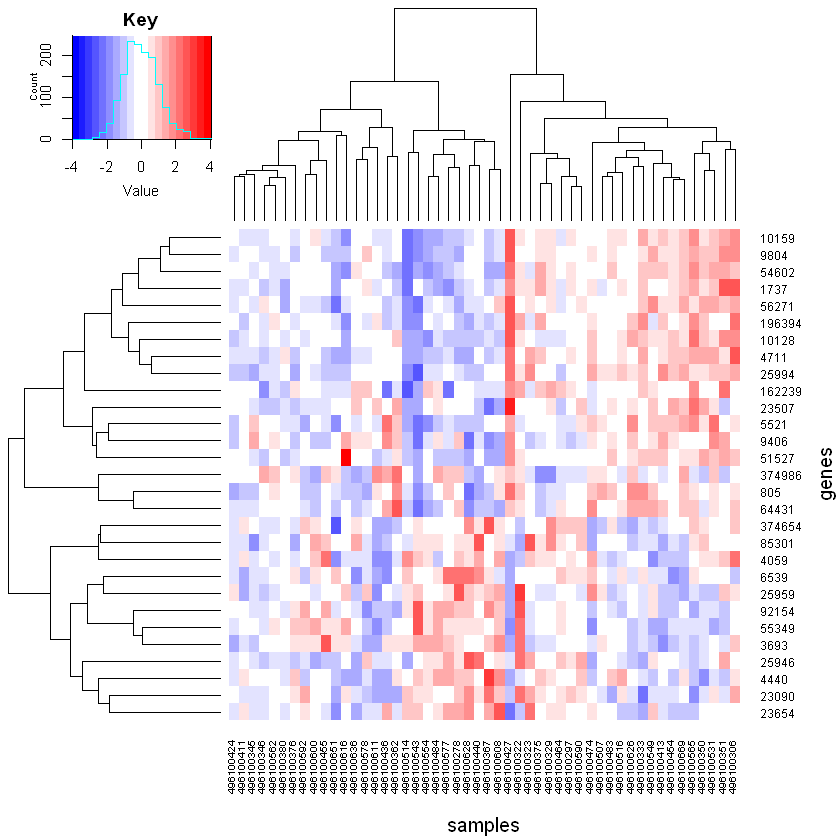

In [10]:
DEG_heatmap(fwm_samples, intersection_genes, 555, 25)

The samples roughly cluster into two groups, presumably according to dementia status. There are two major types of expression patterns/gene clusters present as well.  

We know that these 29 genes are all differentially expressed in the four brain regions but do they exhibit the same pattern? That is: If gene X is upregulated in one brain region, is it upregulated in all the others, or upregulated in some and downregulated in others? We can use the heatmap to quickly get an idea if this might be the case. Let's look at the same genes but randomly choose samples from any of the four brain regions. 

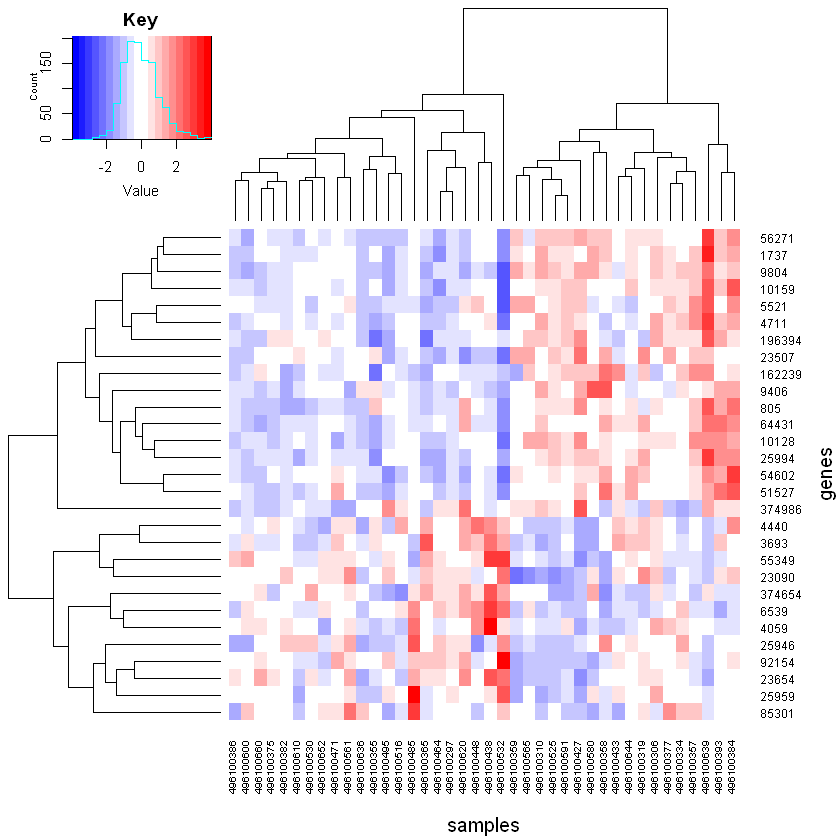

In [11]:
DEG_heatmap(all_samples, intersection_genes, 555, 20)

The pattern looks similar but, to be sure, we'll check directly. Here, we re-run the hypothesis tests on just the 29 intersection genes and use `decideTestsDGE()` to classify the results as either up- or downregulated based on two things:  

1. The adjusted p-values for the tests (all of these will be significant at the $\alpha = 0.05$ significance level), and;  
2. The $log_2$ fold change in expression level versus control.  

We'll grab the names of the genes and use the `ggplot2` library to visualize the results.

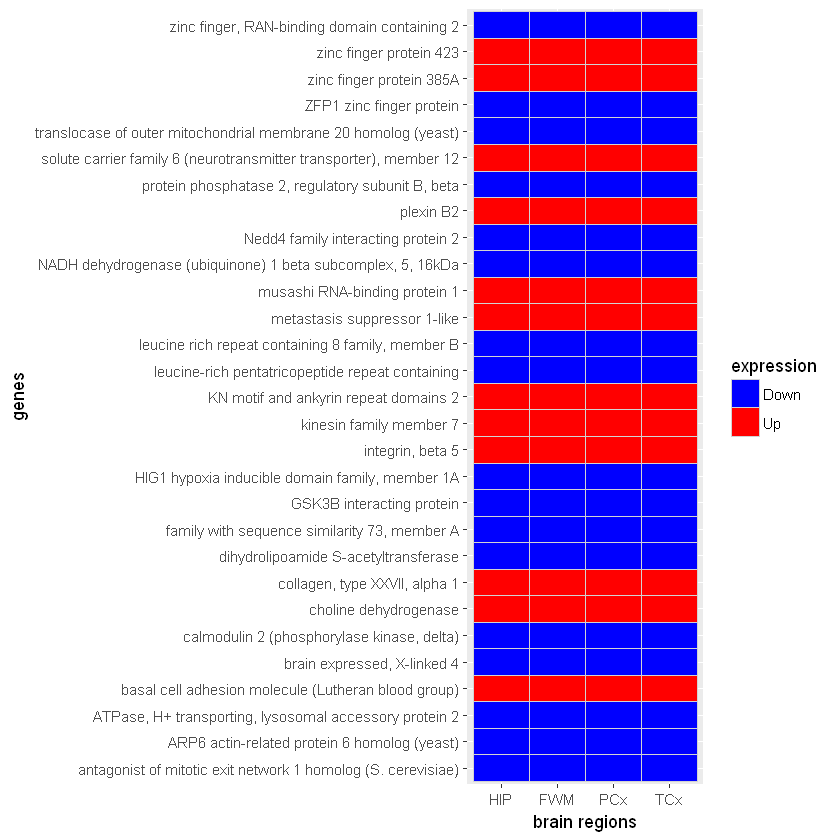

In [12]:
# function runs exact tests on the normalized counts for subsets of genes/samples & classifies them as upregulated 
# or downregulated in dementia samples
compare_gene_subset <- function(x_norm, gene_list, ...){
    x_exact_tests <- exactTest(x_norm[rownames(x_norm) %in% gene_list, ],
                               pair = c('No Dementia', 'Dementia'),
                               dispersion = 'auto')
    x_exact_test_classifications <- decideTestsDGE(x_exact_tests, p.value = 0.05)
    return(x_exact_test_classifications)
}

hip_classifications <- compare_gene_subset(hip_norm, intersection_genes)
fwm_classifications <- compare_gene_subset(fwm_norm, intersection_genes)
pcx_classifications <- compare_gene_subset(pcx_norm, intersection_genes)
tcx_classifications <- compare_gene_subset(tcx_norm, intersection_genes)

# recursive merge on gene ID to construct results dataframe
hip_fwm <- merge(as.data.frame(hip_classifications), as.data.frame(fwm_classifications), by='row.names', all=TRUE)
rownames(hip_fwm) <- hip_fwm$Row.names
hip_fwm$Row.names <- NULL
colnames(hip_fwm) <- c('HIP','FWM')

hip_fwm_pcx <- merge(hip_fwm, as.data.frame(pcx_classifications), by='row.names', all=TRUE)
rownames(hip_fwm_pcx) <- hip_fwm_pcx$Row.names
hip_fwm_pcx$Row.names <- NULL
colnames(hip_fwm_pcx) <- c('HIP','FWM','PCx')

all_regions <- merge(hip_fwm_pcx, as.data.frame(tcx_classifications), by='row.names', all=TRUE)
rownames(all_regions) <- all_regions$Row.names
all_regions$Row.names <- NULL
colnames(all_regions) <- c('HIP','FWM','PCx','TCx')

# make row names a column called gene_entrez_id
all_regions$gene_entrez_id <- rownames(all_regions)
rownames(all_regions) <- NULL

# Merge with gene info on gene_entrez_id
merged_results <- merge(genes, all_regions, by='gene_entrez_id', all=FALSE)

# subset merged_results to just gene_name + results for the 4 brain regions
class_results <- merged_results[ , c('gene_name','HIP','FWM','PCx','TCx')]

# replace 1s with 'Up' and -1s with 'Down'
class_results <- replace(class_results, class_results == 1, 'Up')
class_results <- replace(class_results, class_results == -1, 'Down')

# use melt() from the reshape2 library to reshape the dataframe
melted_class_results <- melt(class_results, id.vars='gene_name')

# use ggplot2 to visualize the classification results
ggplot(data = melted_class_results, aes(x = variable, y = gene_name)) + 
  geom_tile(aes(fill = value), color = 'lightgray', show.legend = TRUE) + 
  labs(x = 'brain regions', y = 'genes', fill = 'expression') + 
  scale_fill_manual(values = c('blue', 'red'))

We can clearly see that the directions of differential expression in dementia for these genes are the same across the four brain regions.  

### Conclusions & next steps
Here, we took a look at some of the ways a gene expression level dataset can be explored using differential expression analysis. The intersection genes we examined as an example might be useful as indicators of changes in "brain-wide" processes occuring with dementia. Several of them have already been found to be associated with Alzheimer's or other forms of dementia. You'll find links to their Gene database entries and some summary information about them in [this Google Sheet](https://docs.google.com/spreadsheets/d/1MEMTRDbWPT3hKXPOYBP1IU5oRj9tIMwSea_7h2dlQmo/edit?usp=sharing).  

The next step is to develop features that we can use in subsequent models of dementia status. We'll need to balance the desire to use as much of the information from the tissue samples as we can with the need to eliminate variables that would only contribute noise. The differential expression analysis gives us a way of reducing the size of the pool of potential gene expression features to include only those most likely to co-vary with dementia risk. To this end, we can reasonably use either a combined list from a differential analysis on subgroups (like the brain region groups used here) or a single list produced from an analysis of all the samples together as ways of reducing the size of the dataset. It should be noted that the amount of the reduction (or the number of genes we determine to be differentially-expressed) will depend on the filter settings we use prior to running the hypothesis tests (see the discussion of filtering in [this previous post](http://blog.vislaywade.com/EDA-gene-expression-data-part-1-multidimensional-scaling/)) and the adjusted p-value cutoff we choose.  

This method achieves the goal of modest reduction in dataset size while preserving those features most relevent to predicting dementia risk; combining the lists of significant genes for the four brain regions that we generated here reduces the gene expression data set to 7180 genes. In the next step, we'll look at ways to combine these features into meaningful groups using unsupervised learning methods.